# basic continuous/discreate leaft system
ci sono problemi con il logger, sembra che la classe utilizzata (<code>LogOutput</code>)non esista piu in drake, e che sia stata sostituita con 
<code>LogVectorOutput</code>

In [1]:
%%capture
try:
    import pydrake
except ImportError:
# TODO(russt): switch to this drake URL.
    !curl -s https://raw.githubusercontent.com/RobotLocomotion/drake/master/setup/jupyter_setup.py > jupyter_setup.py
  #  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_drake
    setup_drake() 
    

In [2]:
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

q = Variable('q')
discrete_vect_sys = SymbolicVectorSystem(
    state=[q], dynamics=[q**3], output=[q]
)

Text(0, 0.5, 'y(t)')

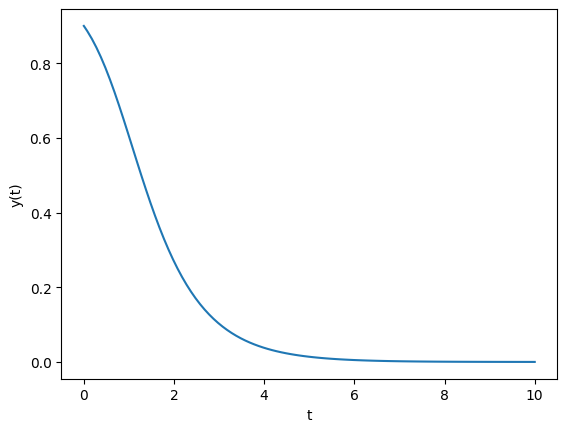

In [68]:
from pydrake.systems.framework import BasicVector, LeafSystem

# ---------------------------------
class SimpleContinuousTimeSystem(LeafSystem): 

    
    def __init__(self):         
        LeafSystem.__init__(self)
        self.DeclareContinuousState(1)
        self.DeclareVectorOutputPort(
            'q_dot', 
            BasicVector(1),
            self.CopyStateOutput
        )
        self.DeclareVectorInputPort(
            'q', 
            BasicVector(1)
        )
        
    def DoCalcTimeDerivatives(self, context, derivatives): 
        q = context.get_continuous_state_vector().GetAtIndex(0)
        q_dot = -q + q**3
        derivatives.get_mutable_vector().SetAtIndex(0, q_dot)
    
    
    def CopyStateOutput(self, context, output): 
        q = context.get_continuous_state_vector().CopyToVector()
        output.SetFromVector(q)

# ---------------------------------
# TEST-CONTINUOS_TIME
system = SimpleContinuousTimeSystem()

from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput


builder = DiagramBuilder()
system = builder.AddSystem(SimpleContinuousTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# ---------------------------------
# PLOT 
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')
# ---------------------------------

In [28]:

class SimpleDiscreteTimeSystem(LeafSystem): 
    
    def __init__(self): 
        LeafSystem.__init__(self)
        self.DeclareDiscreteState(1)
        self.DeclareVectorOutputPort(
            'q_prime', 
            BasicVector(1), 
            self.CopyStateOut
        )
        self.DeclarePeriodicDiscreteUpdate(1.0)
        
    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        q = context.get_discrete_state_vector().GetAIndex(0)
        q_prime = q**3
        discrete_state.get_mutable_vector().SetAtIndex(0, q_prime)
    
    def CopyStateOut(self, context, output):
        q = context.get_discrete_state_vector().CopyToVector()
        output.SetFromVector(x)

        
# ---------------------------------
# TEST-DISCRETE TIME 
discrete_system = SimpleDiscreteTimeSystem()


# ---------------------------------

/tmp/ipykernel_12491/268704989.py:11: DrakeDeprecationWarning: (Deprecated.)

Deprecated:
    Use DeclarePeriodicDiscreteUpdateNoHandler() instead This will be
    removed from Drake on or after 2023-03-01.
  self.DeclarePeriodicDiscreteUpdate(1.0)


In [69]:
from IPython.display import HTML
import numpy as np

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.analysis import Simulator
from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import GenerateHtml
from pydrake.systems.primitives import LogVectorOutput



In [76]:
builder = DiagramBuilder()

pendulum = builder.AddSystem(PendulumPlant())
pendulum.set_name("pendulum")

controller = builder.AddSystem(PidController(
    kp=[10.], 
    ki=[1.], 
    kd=[1.]
))
controller.set_name('controller')

builder.Connect(
    pendulum.get_state_output_port(), 
    controller.get_input_port_estimated_state()
)
builder.Connect(
    controller.get_output_port(), pendulum.get_input_port()
)

builder.ExportInput(controller.get_input_port_desired_state())

logger = LogVectorOutput(pendulum.get_output_port(), builder)
logger.set_name('logger')

diagram = builder.Build()
diagram.set_name('diagram')

HTML(GenerateHtml(diagram))



TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. pydrake.systems.primitives.ConstantVectorSource_[float](source_value: numpy.ndarray[numpy.float64[m, 1]])

Invoked with: BasicVector_[float]([0.0])

In [75]:
from pydrake.systems.primitives import ConstantVectorSource

In [74]:
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

desired_angle = np.pi/2
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context)

port = system.get_input_port()
port.FixValue(0, 0.)

logger.reset()
simulator.AdvanceTo(20)
t = logger.sample_times()

TypeError: FixValue(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.systems.framework.InputPort_[float], context: pydrake.systems.framework.Context_[float], value: pydrake.common.value.AbstractValue) -> pydrake.systems.framework.FixedInputPortValue
    2. (self: pydrake.systems.framework.InputPort_[float], context: pydrake.systems.framework.Context_[float], value: object) -> pydrake.systems.framework.FixedInputPortValue

Invoked with: <pydrake.systems.framework.InputPort_[float] object at 0x7f11a5fd13b0>, 0, 0.0

<h5> INVERTED PENDULUM</h5>

In [11]:
from pydrake.systems.framework import VectorSystem

In [13]:
class SimpleContinuosTimeSystem(VectorSystem): 
    
    def __init__(self): 
        VectorSystem.__init__(self, 0, 1)
        self._DeclareContinuosState(1)
        
    def _DoCalcVectorTimeDerivative(self, context, u, x, xdot): 
        xdot[:] = -xypl + x**3
    
    def _DoCalcVectorOutput(self, context, u, x, y): 
        y[:] = x

In [14]:
import matplotlib.pyplot as plt
from pydrake.all import (DiagramBuilder, SignalLogger, Simulator)b

ImportError: cannot import name 'SignalLogger' from 'pydrake.all' (/home/dema/PycharmProjects/robot_manipulator/lib/python3.10/site-packages/pydrake/all.py)

In [15]:
from pydrake.systems.primitives import LogVectorOutput

# JACOB HACKETT tutorial
directly use of <code>LogVectorOutput</code>

In [8]:
import pydrake.symbolic
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

# CONST PARAMS: 
g = 9.81
L = 1

# SYMBOLIC PARAMS
theta = Variable('theta')
theta_dot = Variable('theta_dot')

states = [theta, theta_dot]
odes =  [theta_dot, -g/L*pydrake.symbolic.sin(theta)]

continuous_vector_system = SymbolicVectorSystem(
    state=states, 
    dynamics=odes, 
    output=states
)


In [9]:
import numpy as np
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()
system = builder.AddSystem(continuous_vector_system)
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()



In [10]:
context = diagram.CreateDefaultContext()
context.SetContinuousState([
    np.pi/4.0,   # theta(0)
    0.0          # theta_dot(0)
])


In [11]:
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)


log = logger.FindLog(context)
time = log.sample_times()
data = log.data().transpose()
theta = data[:, 0]
theta_dot = data[:, 1]

## Animation

In [12]:
simulation_size = len(time)
x = np.zeros(simulation_size)
y = np.zeros(simulation_size)

for i in range(simulation_size): 
    x[i] = L*np.sin(theta[i])
    y[i] = -L*np.cos(theta[i])

time_steps = []
average_time_step = 0
for i in range(simulation_size -1): 
    timestep = abs(time[i] - time[i+1])
    time_steps.append(timestep)

average_time_step = sum(time_steps)/len(time_steps)

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

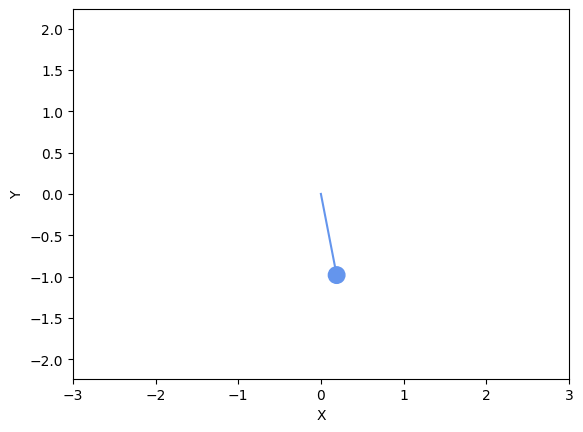

In [16]:
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegFileWriter
from matplotlib.patches import Circle

fig, ax = plt.subplots()
plot, = ax.plot([], [], color='cornflowerblue')
ax.axis('equal')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_xlabel('X')
ax.set_ylabel('Y')
video_title = 'pendulum'


c = Circle( (0, 0), radius=0.1, color='cornflowerblue')
ax.add_patch(c)

FPS = 20 # frame per sec
dt = average_time_step
sample_rate = int(1/(FPS*dt))
dpi = 300 # video quality
writeObj = FFMpegFileWriter(fps=FPS)
video_path_1 = './'+video_title+'.mp4'

with writeObj.saving(fig, video_path_1, dpi): 
    
    for i in range(0, simulation_size, sample_rate): 
        x_data_points = [0, x[i]]
        y_data_points = [0, y[i]]
        plot.set_data(x_data_points, y_data_points)
        
        patch_center = x[i], y[i]
        c.center = patch_center
        
        fig.canvas.draw()
        writeObj.grab_frame()
        

In [ ]:
from I